Here we use the `Sampler` primitive to visualize the resulting state vector after any sequence of measurements of our chain.

#### Hamiltonians

In [49]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import CouplingMap

# Parameters
num_spins = 3
time_step = 0.5
J_x = 1
J_z = 1

# Creating chains
# Open chain
open_chain = CouplingMap.from_line(num_qubits=num_spins, bidirectional=False)
# Closed chain
closed_chain = CouplingMap.from_ring(num_qubits=num_spins, bidirectional=False)

# Listing edges
open_edgelist = open_chain.graph.edge_list()
closed_edgelist = closed_chain.graph.edge_list()

# Building Hamiltonians
open_hamlist = []
closed_hamlist = []

## Open chain
open_hamlist.append(('XX', open_edgelist[0], -J_x)) # Spin 1

for edge in open_edgelist[1:num_spins-1]:
    open_hamlist.append(('ZZ', edge, -J_z)) # Spin 2 to N

open_hamiltonian = SparsePauliOp.from_sparse_list(obj=open_hamlist, num_qubits=num_spins)

## Closed chain
closed_hamlist.append(('XX', closed_edgelist[0], -J_x)) # Spin 1

for edge in closed_edgelist[1:num_spins-1]:
    closed_hamlist.append(('ZZ', edge, -J_z)) # Spins 1 to N-1

closed_hamlist.append(('XX', closed_edgelist[num_spins-1], -J_z)) # Spin N

closed_hamiltonian = SparsePauliOp.from_sparse_list(obj=closed_hamlist, num_qubits=num_spins)

#### Time-evolution

In [50]:
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter

# Number of trotterization layers
trotter_factory = LieTrotter(reps=4)

# Open chain
open_U = PauliEvolutionGate(open_hamiltonian, time=time_step)
open_U_qc = trotter_factory.synthesize(open_U)

# Closed chain
closed_U = PauliEvolutionGate(closed_hamiltonian, time=time_step)
closed_U_qc = trotter_factory.synthesize(closed_U)

#### Simulation

In [51]:
from qiskit.circuit import QuantumCircuit

# Further parameters
num_steps = 1

# Building circuits
# Open chain
open_qc = QuantumCircuit(num_spins, 2)
open_qc.compose(open_U_qc, inplace=True)

for j in range(num_steps):
    open_qc.measure([0, num_spins-1], [0, 1])
    open_qc.compose(open_U_qc, inplace=True)
    
# Closed chain
closed_qc = QuantumCircuit(num_spins, 2)
closed_qc.compose(closed_U_qc, inplace=True)

for j in range(num_steps):
    closed_qc.measure([0, num_spins-1], [0, 1])
    closed_qc.compose(closed_U_qc, inplace=True)

In [52]:
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Calling backend, transpiler and Sampler
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(optimization_level=2, backend=backend)
sampler = Sampler(mode=backend)

# Transpiling circuits
open_qc.measure_all()
closed_qc.measure_all()
isa_open_qc = pass_manager.run(open_qc)
isa_closed_qc = pass_manager.run(closed_qc)

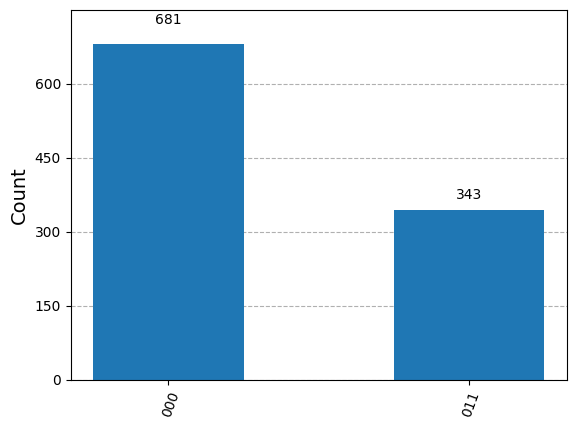

In [53]:
from qiskit.visualization import plot_histogram

# Open chain
# Running sampler
open_job = sampler.run(pubs=[isa_open_qc])
open_counts = open_job.result()[0].data.meas.get_counts()

# Visualizing counts
plot_histogram(open_counts)

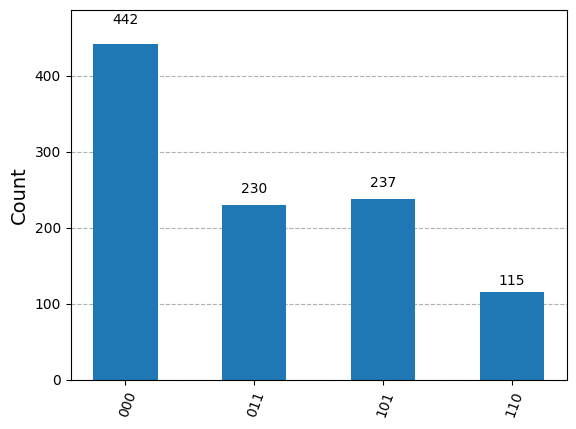

In [54]:
# Open chain
# Closed chain
closed_job = sampler.run(pubs=[isa_closed_qc])
closed_counts = closed_job.result()[0].data.meas.get_counts()

# Visualizing counts
plot_histogram(closed_counts)